# Detekcija i rešavanje osmosmerke

In [1]:
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import pytesseract
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = 25, 15

In [2]:
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

def image_to_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def image_to_bin(image_gs):
    height, width = image_gs.shape[0:2]
    image_binary = np.ndarray((height, width), dtype=np.uint8)
    ret, image_bin = cv2.threshold(image_gs, 127, 255, cv2.THRESH_BINARY)
    return image_bin

def dilate(image):
    kernel = np.ones((3, 3)) # strukturni element 3x3 blok
    return cv2.dilate(image, kernel, iterations=1)

def erode(image):
    kernel = np.ones((3, 3)) # strukturni element 3x3 blok
    return cv2.erode(image, kernel, iterations=1)

def resize_region(region):
    return cv2.resize(region, (28, 28), interpolation=cv2.INTER_NEAREST)

# dobavljanje povrsine unutar okvira osmosmerke
def get_sorted_areas(contours):
    areas = []
    for contour in contours:
        areas.append(cv2.contourArea(contour))
    areas.sort()
    return areas

# selektovanje i vraćanje okvira osmosmerke
def find_frame(image_bin, contours):
    frame_area = get_sorted_areas(contours)[-2]
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour) 
        area = cv2.contourArea(contour) 
        if area == frame_area:
            return (x, y, w, h)

def crop_to_frame(image, frame):
    x, y, w, h = frame
    return image[y:y+h+1, x:x+w+1]

def remove_image(wordsearch, contours):
    mask = np.zeros(wordsearch.shape[:2], dtype=np.uint8)
    areas = get_sorted_areas(contours)
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour) 
        area = cv2.contourArea(contour)
        if area == areas[-3] and areas[-4] < areas[-3]/5:
            cv2.rectangle(mask, (x, y), (x + w, y + h), (255, 0, 0), -1)
    return mask
    
# selektovanje regiona oko slova zadatih reči
def select_letters(image_bin, contours, frame):
    mask = np.zeros(image_bin.shape[:2], dtype=np.uint8)
    sorted_regions = [] 
    regions_array = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour) 
        area = cv2.contourArea(contour) # area se računa kako bi izbacili šumove
        if area > 150 and h < 100 and h > 30:
            # frame[0] je x koordinata gornjeg levog ćoška frame-a, frame[1] je y koordinata, a frame[3] je visina frame-a
            if x < frame[0] or y > frame[1] + frame[3]:
                region = image_bin[y:y+h+1, x:x+w+1]             
                regions_array.append([resize_region(region), (x, y, w, h)]) 
                cv2.rectangle(mask, (x, y), (x + w, y + h), (255, 0, 0), -1)
    
    regions_array = sorted(regions_array, key=lambda x: x[1][0])
    sorted_regions = [region[0] for region in regions_array]
    sorted_rectangles = [region[1] for region in regions_array]
    region_distances = []
    # izdvojiti sortirane parametre opisujućih pravougaonika
    # izračunati rastojanja između svih susednih regiona po x-osi i dodati ih u niz rastojanja
    for index in range(0, len(sorted_rectangles) - 1):
        current = sorted_rectangles[index]
        next_rect = sorted_rectangles[index + 1]
        distance = next_rect[1] - (current[1] + current[3]) # x_next - (x_current + w_current)
        region_distances.append(distance)
    
    return sorted_regions, mask

def display_image(image, color=False):
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')

def image_smoothening(img):
    ret1, th1 = cv2.threshold(img, 180, 255, cv2.THRESH_BINARY)
    ret2, th2 = cv2.threshold(th1, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    blur = cv2.GaussianBlur(th2, (1, 1), 0)
    ret3, th3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return th3

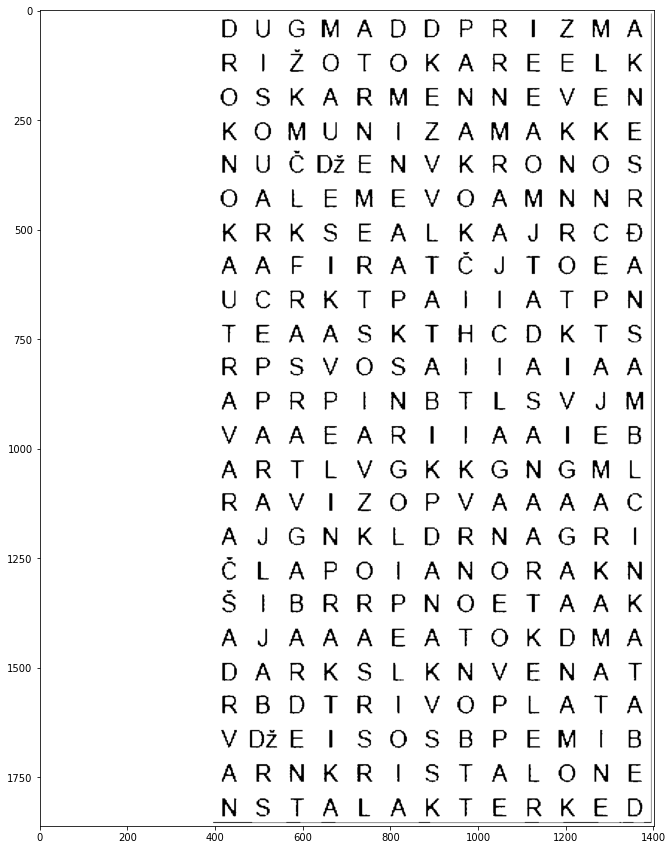

In [3]:
image_color = load_image('data/308vx - 01.jpg')
image_bin = image_to_bin(image_to_gray(image_color))
image_bin = image_smoothening(image_bin)
image_bin = dilate(erode(image_bin))

all_contours, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
frame = find_frame(image_bin, all_contours)
wordsearch = crop_to_frame(image_bin, frame)

ws_contours, hierarchy = cv2.findContours(wordsearch.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
mask = remove_image(wordsearch, ws_contours)
res = cv2.bitwise_and(wordsearch, wordsearch, mask=mask)
res[mask==0] = 255
display_image(res)

In [4]:
ls = pytesseract.image_to_string(wordsearch, lang='srp_latn') # slova u osmosmerci
print(len(ls))

TesseractError: (1, 'Error opening data file /usr/local/share/tessdata/srp_latn.traineddata Please make sure the TESSDATA_PREFIX environment variable is set to your "tessdata" directory. Failed loading language \'srp_latn\' Tesseract couldn\'t load any languages! Could not initialize tesseract.')

In [ ]:
letters, mask = select_letters(image_bin, all_contours, frame) 

print("Broj prepoznatih regiona: ", len(letters))
res = cv2.bitwise_and(image_bin, image_bin, mask=mask)
res[mask==0] = 255
display_image(res)

In [ ]:
words = pytesseract.image_to_string(res, lang='srp_latn').split() # zadate reči
print(words)